In [24]:
import zipfile
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
import pandas as pd
from tqdm.auto import tqdm

# Define paths
train_zip_path = '/content/drive/MyDrive/Task 3/train.zip'
test_zip_path = '/content/drive/MyDrive/Task 3/test1.zip'

In [25]:
# Function to load images and labels directly from zip file based on filename patterns
def load_images_and_labels_from_zip(zip_path):
    images = []
    labels = []
    filenames = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if file_info.filename.endswith('.jpg') or file_info.filename.endswith('.png'):
                label = 'cats' if 'cat' in file_info.filename.lower() else 'dogs'
                filenames.append(file_info.filename)
                with zip_ref.open(file_info.filename) as file:
                    img_array = np.frombuffer(file.read(), np.uint8)
                    img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (64, 64))
                        images.append(img.flatten())
                        labels.append(0 if label == 'cats' else 1)
    return np.array(images), np.array(labels), filenames

# Function to load images directly from zip file without labels
def load_images_from_zip(zip_path):
    images = []
    filenames = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if file_info.filename.endswith('.jpg') or file_info.filename.endswith('.png'):
                with zip_ref.open(file_info.filename) as file:
                    img_array = np.frombuffer(file.read(), np.uint8)
                    img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (64, 64))
                        images.append(img.flatten())
                        filenames.append(file_info.filename)
    return np.array(images), filenames

# Load training images and labels
X_train, y_train, filenames = load_images_and_labels_from_zip(train_zip_path)

In [26]:
for i in range(20):
    print(f"Filename: {filenames[i]}, Label: {'cat' if y_train[i] == 0 else 'dog'}")

# Debugging: Check the distribution of labels
print(f"Number of samples in the dataset: {len(y_train)}")
print(f"Number of cat samples: {np.sum(y_train == 0)}")
print(f"Number of dog samples: {np.sum(y_train == 1)}")

# Check if we have more than one class
if len(np.unique(y_train)) < 2:
    raise ValueError("The number of classes has to be greater than one; check your dataset.")

Filename: train/cat.11036.jpg, Label: cat
Filename: train/cat.11037.jpg, Label: cat
Filename: train/cat.11038.jpg, Label: cat
Filename: train/cat.11039.jpg, Label: cat
Filename: train/cat.1104.jpg, Label: cat
Filename: train/cat.11040.jpg, Label: cat
Filename: train/cat.11041.jpg, Label: cat
Filename: train/cat.11042.jpg, Label: cat
Filename: train/cat.11043.jpg, Label: cat
Filename: train/cat.11044.jpg, Label: cat
Filename: train/cat.11045.jpg, Label: cat
Filename: train/cat.11046.jpg, Label: cat
Filename: train/cat.11047.jpg, Label: cat
Filename: train/cat.11048.jpg, Label: cat
Filename: train/cat.11049.jpg, Label: cat
Filename: train/cat.1105.jpg, Label: cat
Filename: train/cat.11050.jpg, Label: cat
Filename: train/cat.11051.jpg, Label: cat
Filename: train/cat.11052.jpg, Label: cat
Filename: train/cat.11053.jpg, Label: cat
Number of samples in the dataset: 23845
Number of cat samples: 11345
Number of dog samples: 12500


In [27]:
# Split the subset data into training and testing sets
X_train, X_test_split, y_train, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the SVM model with progress bar
svm_model = SVC(kernel='linear')
batch_size = 100  # Define batch size
num_batches = int(np.ceil(len(X_train) / batch_size))
for i in tqdm(range(num_batches), desc="Training SVM", unit="batch"):
    start = i * batch_size
    end = min((i + 1) * batch_size, len(X_train))
    svm_model.fit(X_train[start:end], y_train[start:end])

# Save the trained model
joblib.dump(svm_model, 'svm_cat_dog_classifier.pkl')
print("Model saved as 'svm_cat_dog_classifier.pkl'")

Training SVM:   0%|          | 0/191 [00:00<?, ?batch/s]

Model saved as 'svm_cat_dog_classifier.pkl'


In [30]:
# Load the test images
X_test, test_filenames = load_images_from_zip(test_zip_path)

# Load the trained model
svm_model = joblib.load('svm_cat_dog_classifier.pkl')

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Save the predictions to a CSV file
predictions_df = pd.DataFrame({
    'Filename': test_filenames,
    'PredictedLabel': y_pred
})
predictions_df['PredictedLabel'] = predictions_df['PredictedLabel'].map({0: 'cat', 1: 'dog'})
predictions_df.to_csv('test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv'")

Predictions saved to 'test_predictions.csv'


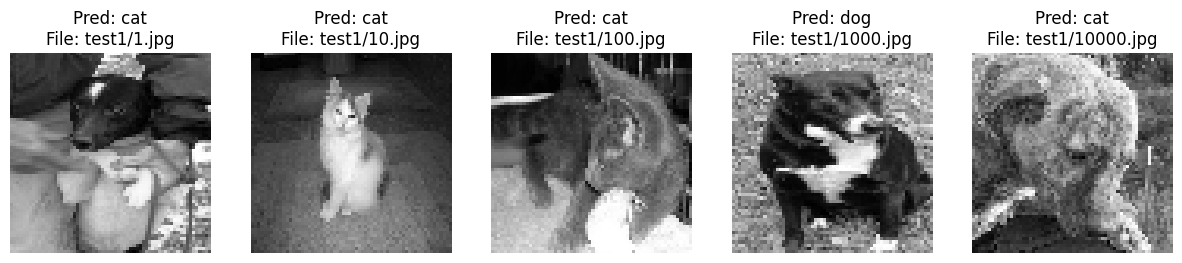

In [29]:
import matplotlib.pyplot as plt
# Display some of the predicted images with labels
def display_images(images, labels, predicted_labels, filenames, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = images[i].reshape(64, 64)
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f"Pred: {predicted_labels[i]}\nFile: {filenames[i]}")
        ax.axis('off')
    plt.show()

# Display the first 5 images with their predicted labels
display_images(X_test[:5], None, predictions_df['PredictedLabel'][:5].values, test_filenames[:5])